## Quantum-Enhanced Language Model Fine-Tuning with Merlin

This notebook demonstrates how to fine-tune language models using quantum photonic circuits as classification heads. We compare classical approaches (Logistic Regression, SVM, MLP) with quantum photonic classifiers implemented using the Merlin framework.


 ## 1. Setup and Imports

 First, we'll import all necessary libraries and set up our environment. This includes:
 - PyTorch for neural network operations
 - SetFit for few-shot learning
 - Merlin for quantum photonic circuit simulation
 - Standard ML libraries for evaluation and data handling



In [2]:
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
import merlin as ML  # Using our Merlin framework
import math
import json
import os
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
from setfit import SetFitModel, sample_dataset
from sklearn.svm import SVC

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


## 1. Setup and Imports

First, we'll import all necessary libraries and set up our environment. This includes:
- PyTorch for neural network operations
- SetFit for few-shot learning
- Merlin for quantum photonic circuit simulation
- Standard ML libraries for evaluation and data handling

In [3]:
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def tokenize(self, texts):
        """
        Delegates tokenization to the underlying model.

        Args:
            texts (List[str]): List of text strings to tokenize

        Returns:
            Dict or Tensor: Tokenized inputs in the format expected by the model
        """
        try:
            # Try to use the tokenize method of the underlying model
            return self.model.tokenize(texts)
        except AttributeError:
            # If the model doesn't have a tokenize method, try alternative approaches
            if hasattr(self.model, 'tokenizer'):
                return self.model.tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
            elif hasattr(self.model, '_first_module') and hasattr(self.model._first_module, 'tokenizer'):
                return self.model._first_module.tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
            else:
                raise ValueError(
                    "Unable to tokenize texts with this model. Please provide a model that has a tokenize or tokenizer method.")

    def forward(self, inputs):
        """
        Process inputs through the model to get embeddings.

        Args:
            inputs: Can be raw text strings or pre-tokenized inputs

        Returns:
            torch.Tensor: The sentence embeddings
        """
        try:
            # Handle different input formats
            if isinstance(inputs, dict) and all(isinstance(v, torch.Tensor) for v in inputs.values()):
                outputs = self.model(inputs)
            elif isinstance(inputs, list) and all(isinstance(t, str) for t in inputs):
                tokenized = self.tokenize(inputs)
                device = next(self.model.parameters()).device
                tokenized = {k: v.to(device) for k, v in tokenized.items()}
                outputs = self.model(tokenized)
            else:
                outputs = self.model(inputs)

            # Extract embeddings from various output formats
            if isinstance(outputs, dict) and "sentence_embedding" in outputs:
                return outputs["sentence_embedding"]
            elif isinstance(outputs, dict) and "pooler_output" in outputs:
                return outputs["pooler_output"]
            elif isinstance(outputs, tuple) and len(outputs) > 0:
                return outputs[0]
            else:
                return outputs
        except Exception as e:
            raise ValueError(f"Error during forward pass: {str(e)}")


## 2. Model Wrapper for Sentence Transformers

The `ModelWrapper` class provides a unified interface for handling tokenization and forward passes with sentence transformer models. This abstraction allows us to work with different model architectures seamlessly.

In [4]:
def evaluate(model, texts, labels):
    """
    Evaluate SetFit model on given texts and labels.

    Args:
        model: SetFit model with a trained classification head
        texts: List of text strings to classify
        labels: True labels for evaluation

    Returns:
        tuple: (accuracy, predictions)
    """
    batch_size = 16
    num_samples = len(texts)
    num_batches = (num_samples + batch_size - 1) // batch_size

    all_embeddings = []

    with torch.no_grad():
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, num_samples)

            batch_texts = texts[start_idx:end_idx]

            # Get embeddings
            batch_embeddings = model.model_body.encode(batch_texts, convert_to_tensor=True)
            batch_embeddings_cpu = batch_embeddings.detach().cpu().numpy()

            all_embeddings.extend(batch_embeddings_cpu)

    # Use the classification head to predict
    predictions = model.model_head.predict(np.array(all_embeddings))
    accuracy = accuracy_score(labels, predictions)
    return accuracy, predictions

## 3. Evaluation Function

This function evaluates a SetFit model on given texts and labels, processing data in batches for efficiency.

In [5]:
class MLPClassifier(nn.Module):
    """3-layer MLP classifier with dropout regularization"""

    def __init__(self, input_dim, hidden_dim=100, num_classes=2):
        super(MLPClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        return self.layers(x)


class MLPClassifierWrapper(BaseEstimator, ClassifierMixin):
    """Scikit-learn compatible wrapper for the MLP classifier"""

    def __init__(self, input_dim=768, hidden_dim=100, num_classes=2,
                 lr=0.001, epochs=100, batch_size=32, device=None):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None
        self.classes_ = None

    def fit(self, X, y):
        """Train the MLP classifier"""
        # Convert numpy arrays to PyTorch tensors
        X = torch.tensor(X, dtype=torch.float32).to(self.device)

        # Store unique classes
        self.classes_ = np.unique(y)
        y_tensor = torch.tensor(y, dtype=torch.long).to(self.device)

        # Initialize the model
        self.model = MLPClassifier(
            input_dim=self.input_dim,
            hidden_dim=self.hidden_dim,
            num_classes=len(self.classes_)
        ).to(self.device)

        print(f"Number of parameters in MLP head: {sum([p.numel() for p in self.model.parameters()])}")

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        # Training loop
        self.model.train()
        for epoch in range(self.epochs):
            # Mini-batch training
            indices = torch.randperm(len(X))
            total_loss = 0

            for i in range(0, len(X), self.batch_size):
                batch_indices = indices[i:i + self.batch_size]
                batch_X = X[batch_indices]
                batch_y = y_tensor[batch_indices]

                # Forward pass
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)

                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            # Print progress
            if (epoch + 1) % 10 == 0:
                avg_loss = total_loss / (len(X) // self.batch_size + 1)
                print(f'Epoch [{epoch + 1}/{self.epochs}], Loss: {avg_loss:.4f}')

        return self

    def predict(self, X):
        """Predict classes for samples"""
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)

        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs, 1)
            return self.classes_[predicted.cpu().numpy()]

    def predict_proba(self, X):
        """Predict class probabilities"""
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)

        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            return probabilities


## 4. Classical Classification Heads

### 4.1 MLP Classifier

We implement a 3-layer Multi-Layer Perceptron (MLP) as one of our classical baselines. The architecture includes:
- Input layer matching the embedding dimension (768 for most transformers)
- Two hidden layers with ReLU activation and dropout
- Output layer for classification

In [6]:
def replace_setfit_head_with_mlp(model, input_dim=768, hidden_dim=100, num_classes=2, epochs=100):
    """Replace the classification head of a SetFitModel with an MLP."""
    # Get the device the model is on
    device = next(model.model_body.parameters()).device

    # Create new MLP head
    mlp_head = MLPClassifierWrapper(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        num_classes=num_classes,
        epochs=epochs,
        lr=0.001,
        device=device
    )

    # Replace the model head
    model.model_head = mlp_head

    return model

### 4.2 Helper Function to Replace SetFit Head

This function allows us to easily swap the default classification head with our custom MLP.

In [7]:
class QuantumClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=100, modes=10, num_classes=2, input_state=None):
        super(QuantumClassifier, self).__init__()

        # This layer downscales the inputs to fit in the QLayer
        self.downscaling_layer = nn.Linear(input_dim, hidden_dim)

        # Building the QLayer with Merlin
        experiment = ML.PhotonicBackend(
            circuit_type=ML.CircuitType.SERIES,
            n_modes=modes,
            n_photons=sum(input_state) if input_state else modes // 2,
            state_pattern=ML.StatePattern.PERIODIC
        )

        # Default input state
        if input_state is None:
            input_state = [(i + 1) % 2 for i in range(modes)]

        photons_count = sum(input_state)
        # PNR (Photon Number Resolving) output size
        #output_size_slos = math.comb(modes + photons_count - 1, photons_count)

        # Create ansatz for the quantum layer
        ansatz = ML.AnsatzFactory.create(
            PhotonicBackend=experiment,
            input_size=hidden_dim,
           # output_size=output_size_slos,
            output_mapping_strategy=ML.OutputMappingStrategy.NONE
        )

        # Build the QLayer using Merlin
        self.q_circuit = ML.QuantumLayer(input_size=hidden_dim, ansatz=ansatz)

        # Linear output layer as in the original paper
        self.output_layer = nn.Linear(self.q_circuit.output_size, num_classes)

    def forward(self, x):
        # Forward pass through the quantum-classical hybrid
        x = self.downscaling_layer(x)
        x = torch.sigmoid(x)  # Normalize for quantum layer
        x = self.q_circuit(x)
        return self.output_layer(x)

## 5. Quantum Classification Head

### 5.1 Quantum Photonic Classifier

The quantum classifier uses a photonic interferometer implemented with the Merlin framework. The architecture consists of:

1. **Downscaling layer**: Reduces the embedding dimension to match quantum circuit requirements
2. **Quantum photonic circuit**: Processes the downscaled features through quantum interference
3. **Output layer**: Maps quantum measurements to class predictions

The quantum circuit parameters:
- **Modes**: Number of optical modes in the interferometer
- **Photons**: Number of photons in the input state
- **Input state**: Distribution of photons across modes

In [8]:
class QLayerTraining(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim=768, hidden_dim=100, modes=10, num_classes=2,
                 dropout_rate=0.2, lr=0.001, weight_decay=1e-5,
                 epochs=100, batch_size=32, device=None, input_state=None):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.modes = modes
        self.input_state = input_state
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.lr = lr
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')

        # Initialize model
        self.model = None
        self.classes_ = None
        self.is_fitted_ = False
        # Training history
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_accuracy': []
        }

    def _initialize_model(self):
        """Initialize or re-initialize the model."""
        self.model = QuantumClassifier(
            input_dim=self.input_dim,
            hidden_dim=self.hidden_dim,
            modes=self.modes,
            num_classes=len(self.classes_),
            input_state=self.input_state,
        ).to(self.device)

        print(f"Number of parameters in Quantum head: {sum([p.numel() for p in self.model.parameters()])}")

    def _train_epoch(self, train_loader, criterion, optimizer):
        """Train for one epoch."""
        self.model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

            # Forward pass
            outputs = self.model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimizer step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        return epoch_loss / len(train_loader)

    def fit(self, X, y):
        """Train the QLayer with a manual training loop."""
        # Store classes
        self.classes_ = np.unique(y)

        # Initialize model
        self._initialize_model()

        # Convert to PyTorch tensors
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.long)
        train_dataset = TensorDataset(X_tensor, y_tensor)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )

        # Training loop
        for epoch in range(self.epochs):
            # Train for one epoch
            train_loss = self._train_epoch(train_loader, criterion, optimizer)
            self.history['train_loss'].append(train_loss)

            if (epoch + 1) % 50 == 0:
                print(f'Epoch {epoch + 1}/{self.epochs}, Train Loss: {train_loss:.4f}')

        self.is_fitted_ = True
        return self

    def predict(self, X):
        """Predict class labels for samples in X."""
        self._check_is_fitted()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)

        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs, 1)

        return self.classes_[predicted.cpu().numpy()]

    def predict_proba(self, X):
        """Predict class probabilities for samples in X."""
        self._check_is_fitted()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)

        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()

        return probabilities

    def _check_is_fitted(self):
        """Check if model is fitted."""
        if not self.is_fitted_ or self.model is None:
            raise ValueError("This model has not been fitted yet. Call 'fit' before using this method.")

### 5.2 Quantum Layer Training Wrapper

This wrapper provides scikit-learn compatible training for the quantum classifier, including proper initialization, training loops, and prediction methods.

In [10]:
def create_setfit_with_q_layer(model, input_dim=768, hidden_dim=100, modes=10,
                              num_classes=2, epochs=100, input_state=None):
    """
    Replace the classification head of a SetFit model with a quantum layer.

    Args:
        model: SetFit model to modify
        input_dim: Dimension of input embeddings
        hidden_dim: Dimension after downscaling
        modes: Number of modes in the quantum circuit
        num_classes: Number of output classes
        epochs: Training epochs for the quantum head
        input_state: Photon distribution across modes

    Returns:
        Modified SetFit model with quantum classification head
    """
    # Replace model head with QLayer
    model.model_head = QLayerTraining(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        modes=modes,
        num_classes=num_classes,
        epochs=epochs,
        input_state=input_state
    )

    return model

### 5.3 Helper Function for Quantum SetFit Models

In [11]:
def save_experiment_results(results, filename='ft-qllm_exp.json'):
    """
    Append experiment results to a JSON file.

    Args:
        results (dict): Dictionary containing experiment results
        filename (str): Path to the JSON file to store results
    """
    filename = os.path.join("./results", filename)

    # Create results directory if it doesn't exist
    os.makedirs("./results", exist_ok=True)

    # Check if file exists and load existing data
    if os.path.exists(filename):
        try:
            with open(filename, 'r') as file:
                all_results = json.load(file)
        except json.JSONDecodeError:
            all_results = []
    else:
        all_results = []

    # Append new results
    all_results.append(results)

    # Write updated data back to file
    with open(filename, 'w') as file:
        json.dump(all_results, file, indent=4)

    print(f"Results saved. Total experiments: {len(all_results)}")
    return len(all_results)

## 6. Utility Functions

### 6.1 Results Storage

Function to save experimental results in JSON format for later analysis.

In [23]:
class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf."""
    def __init__(self, model, temperature=0.07, contrast_mode="all", base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.model = model
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, sentence_features, labels=None, mask=None):
        """Computes loss for model."""
        # Au lieu d'utiliser encode() qui peut détacher le graphe de calcul,
        # utilisons directement le modèle pour générer les embeddings
        # Tokenize the inputs
        tokenized_inputs = self.model.tokenize(sentence_features[0])

        # Si le modèle est sur un device particulier, déplacer les inputs sur ce device
        device = next(self.model.parameters()).device
        tokenized_inputs = {k: v.to(device) for k, v in tokenized_inputs.items()}

        # Forward pass avec le modèle
        outputs = self.model(tokenized_inputs)

        # Récupérer les embeddings
        if isinstance(outputs, dict) and "sentence_embedding" in outputs:
            features = outputs["sentence_embedding"]
        else:
            # Si le modèle renvoie un format différent, adaptez ici
            features = outputs  # Ou une autre méthode pour extraire les embeddings

        # Normalize embeddings
        features = torch.nn.functional.normalize(features, p=2, dim=1)
        # Add n_views dimension
        features = torch.unsqueeze(features, 1)
        device = features.device

        # Le reste du code reste inchangé
        if len(features.shape) < 3:
            raise ValueError("`features` needs to be [bsz, n_views, ...]," "at least 3 dimensions are required")
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError("Cannot define both `labels` and `mask`")
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError("Num of labels does not match num of features")
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == "one":
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == "all":
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError("Unknown mode: {}".format(self.contrast_mode))

        # Compute logits
        anchor_dot_contrast = torch.div(torch.matmul(anchor_feature, contrast_feature.T), self.temperature)
        # For numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # Tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # Mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0,
        )
        mask = mask * logits_mask

        # Compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # Compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # Loss
        loss = -(self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss


### 6.2 Contrastive Loss Implementation

Simplified supervised contrastive loss for fine-tuning the sentence transformer body. In production, you would implement the full contrastive loss formula.

In [24]:
SAMPLES_PER_CLASS = 8  # Few-shot setting
BODY_EPOCHS = 20      # Epochs for sentence transformer fine-tuning
HEAD_EPOCHS = 200     # Epochs for classification head training
LEARNING_RATE = 1e-5  # Learning rate for body fine-tuning
BATCH_SIZE = 16       # Batch size for evaluation

print(f"Configuration:")
print(f"- Samples per class: {SAMPLES_PER_CLASS}")
print(f"- Body training epochs: {BODY_EPOCHS}")
print(f"- Head training epochs: {HEAD_EPOCHS}")
print(f"- Learning rate: {LEARNING_RATE}")


Configuration:
- Samples per class: 8
- Body training epochs: 20
- Head training epochs: 200
- Learning rate: 1e-05


## 7. Main Training Pipeline

Now we'll set up the complete training pipeline that:
1. Loads the SST-2 sentiment analysis dataset
2. Fine-tunes the sentence transformer with contrastive learning
3. Trains multiple classification heads (classical and quantum)
4. Evaluates and compares all approaches

In [25]:
print(f"\nLoading dataset with {SAMPLES_PER_CLASS} samples per class...")
dataset = load_dataset("sst2")

# Simulate few-shot regime by sampling examples per class
train_dataset = sample_dataset(dataset["train"], label_column="label", num_samples=SAMPLES_PER_CLASS)
eval_dataset = dataset["validation"].select(range(250))
test_dataset = dataset["validation"].select(range(250, len(dataset["validation"])))

# Extract texts and labels
texts = [example["sentence"] for example in train_dataset]
features = [texts]
labels = torch.tensor([example["label"] for example in train_dataset])

print(f"Dataset sizes:")
print(f"- Training: {len(train_dataset)} samples")
print(f"- Validation: {len(eval_dataset)} samples")
print(f"- Test: {len(test_dataset)} samples")


Loading dataset with 8 samples per class...
Dataset sizes:
- Training: 16 samples
- Validation: 250 samples
- Test: 622 samples


### 7.1 Load Dataset

We use the Stanford Sentiment Treebank (SST-2) dataset for binary sentiment classification. In the few-shot setting, we sample only a small number of examples per class for training.

In [26]:
print("\nLoading pre-trained model...")
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")
sentence_transformer = model.model_body
classification_head = model.model_head

print(f"Model loaded: {type(sentence_transformer).__name__}")
print(f"Embedding dimension: 768")


Loading pre-trained model...


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Model loaded: SentenceTransformer
Embedding dimension: 768


### 7.2 Initialize Base Model

We use a pre-trained sentence transformer as our base model. The SetFit framework provides an efficient way to perform few-shot learning.

In [27]:
print("\nTraining model body with contrastive learning...")
model_wrapped = ModelWrapper(sentence_transformer)
criterion = SupConLoss(model=model_wrapped)

# Enable gradients for fine-tuning
for param in sentence_transformer.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model_wrapped.parameters(), lr=LEARNING_RATE)
model_wrapped.train()

# Training loop
for iteration in tqdm(range(BODY_EPOCHS), desc="Contrastive Learning"):
    optimizer.zero_grad()
    loss = criterion(features, labels)
    loss.backward()
    optimizer.step()

    if (iteration + 1) % 5 == 0:
        print(f"Iteration {iteration + 1}/{BODY_EPOCHS}, Loss: {loss.item():.6f}")

print("Model body fine-tuning completed!")


Training model body with contrastive learning...


Contrastive Learning:  30%|███       | 6/20 [00:03<00:04,  3.15it/s]

Iteration 5/20, Loss: 2.355021


Contrastive Learning:  55%|█████▌    | 11/20 [00:04<00:01,  4.93it/s]

Iteration 10/20, Loss: 2.112763


Contrastive Learning:  80%|████████  | 16/20 [00:05<00:00,  5.45it/s]

Iteration 15/20, Loss: 2.109605


Contrastive Learning: 100%|██████████| 20/20 [00:06<00:00,  3.28it/s]

Iteration 20/20, Loss: 2.044540
Model body fine-tuning completed!


### 7.3 Fine-tune Sentence Transformer Body

We fine-tune the sentence transformer using contrastive learning to better adapt it to our specific task.

In [28]:
print("\nGenerating embeddings for training data...")
sentence_transformer.eval()
train_embeddings = []
train_labels = []

with torch.no_grad():
    num_batches = (len(train_dataset["sentence"]) + BATCH_SIZE - 1) // BATCH_SIZE

    for batch_idx in tqdm(range(num_batches), desc="Encoding"):
        start_idx = batch_idx * BATCH_SIZE
        end_idx = min(start_idx + BATCH_SIZE, len(train_dataset["sentence"]))

        batch_texts = train_dataset["sentence"][start_idx:end_idx]
        batch_labels = train_dataset["label"][start_idx:end_idx]

        batch_embeddings = sentence_transformer.encode(batch_texts, convert_to_tensor=True)
        batch_embeddings_cpu = batch_embeddings.detach().cpu().numpy()

        for emb, lbl in zip(batch_embeddings_cpu, batch_labels):
            train_embeddings.append(emb)
            train_labels.append(lbl)

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

print(f"Embeddings shape: {train_embeddings.shape}")
print(f"Labels shape: {train_labels.shape}")


Generating embeddings for training data...


Encoding: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

Embeddings shape: (16, 768)
Labels shape: (16,)


### 7.4 Generate Embeddings

After fine-tuning, we generate embeddings for all training samples. These embeddings will be used to train the various classification heads.

In [29]:
num_classes = len(set(train_dataset["label"]))
results = {
    "training_samples": SAMPLES_PER_CLASS,
    "epochs": BODY_EPOCHS,
    "lr": LEARNING_RATE
}

print(f"\nTraining classification heads for {num_classes}-class classification...")



Training classification heads for 2-class classification...


## 8. Train and Evaluate Classification Heads

Now we'll train different classification heads and compare their performance:
1. **Logistic Regression**: Simple linear classifier (baseline)
2. **SVM**: Support Vector Machine with linear kernel
3. **MLP**: Multi-layer perceptron
4. **Quantum Layers**: Multiple configurations with different numbers of modes and photons

In [30]:
print("\n1. Training Logistic Regression head...")
# Reset to default logistic regression head
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")
model.model_body = sentence_transformer  # Use our fine-tuned body

# Train
model.model_head.fit(train_embeddings, train_labels)

# Evaluate
lg_val_accuracy, _ = evaluate(model, eval_dataset["sentence"], eval_dataset["label"])
lg_test_accuracy, _ = evaluate(model, test_dataset["sentence"], test_dataset["label"])

print(f"Logistic Regression - Val: {lg_val_accuracy:.4f}, Test: {lg_test_accuracy:.4f}")
results["LogisticRegression"] = [lg_val_accuracy, lg_test_accuracy]


1. Training Logistic Regression head...


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/Users/cassandrenotton/Documents/projects/CoreDev/venv-merlin-quandela/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/cassandrenotton/Documents/projects/CoreDev/venv-merlin-quandela/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/cassandrenotton/Documents/projects/CoreDev/venv-merlin-quandela/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/cassandrenotton/Documents/projects/CoreDev/venv-merlin-quandela/lib/python3.12/site-packages/skle

Logistic Regression - Val: 0.8000, Test: 0.7669


/Users/cassandrenotton/Documents/projects/CoreDev/venv-merlin-quandela/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/cassandrenotton/Documents/projects/CoreDev/venv-merlin-quandela/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/cassandrenotton/Documents/projects/CoreDev/venv-merlin-quandela/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


### 8.1 Logistic Regression Head

In [31]:
print("\n2. Training SVM head...")
# Replace head with SVM
model.model_head = SVC(C=1.0, kernel='linear', gamma='scale', probability=True)
model.model_head.fit(train_embeddings, train_labels)

# Evaluate
svc_val_accuracy, _ = evaluate(model, eval_dataset["sentence"], eval_dataset["label"])
svc_test_accuracy, _ = evaluate(model, test_dataset["sentence"], test_dataset["label"])

print(f"SVM - Val: {svc_val_accuracy:.4f}, Test: {svc_test_accuracy:.4f}")
results["SVC"] = [svc_val_accuracy, svc_test_accuracy]


2. Training SVM head...
SVM - Val: 0.8080, Test: 0.7846


### 8.2 SVM Head

In [32]:
print("\n3. Training MLP head...")
# Replace head with MLP
model = replace_setfit_head_with_mlp(
    model,
    input_dim=768,
    hidden_dim=100,
    num_classes=num_classes,
    epochs=HEAD_EPOCHS
)
model.model_head.fit(train_embeddings, train_labels)

# Evaluate
mlp_val_accuracy, _ = evaluate(model, eval_dataset["sentence"], eval_dataset["label"])
mlp_test_accuracy, _ = evaluate(model, test_dataset["sentence"], test_dataset["label"])

print(f"MLP - Val: {mlp_val_accuracy:.4f}, Test: {mlp_test_accuracy:.4f}")
results["MLP"] = [mlp_val_accuracy, mlp_test_accuracy]



3. Training MLP head...
Number of parameters in MLP head: 82052
Epoch [10/200], Loss: 0.4457
Epoch [20/200], Loss: 0.1034
Epoch [30/200], Loss: 0.0177
Epoch [40/200], Loss: 0.0014
Epoch [50/200], Loss: 0.0009
Epoch [60/200], Loss: 0.0002
Epoch [70/200], Loss: 0.0006
Epoch [80/200], Loss: 0.0002
Epoch [90/200], Loss: 0.0001
Epoch [100/200], Loss: 0.0001
Epoch [110/200], Loss: 0.0004
Epoch [120/200], Loss: 0.0002
Epoch [130/200], Loss: 0.0001
Epoch [140/200], Loss: 0.0001
Epoch [150/200], Loss: 0.0002
Epoch [160/200], Loss: 0.0001
Epoch [170/200], Loss: 0.0001
Epoch [180/200], Loss: 0.0001
Epoch [190/200], Loss: 0.0008
Epoch [200/200], Loss: 0.0001
MLP - Val: 0.8040, Test: 0.7701


### 8.3 MLP Head

In [35]:
print("\n4. Training Quantum Layer heads...")
modes_to_test = [ 2, 4, 6, 8]
quantum_results = {}

for mode in modes_to_test:
    photon_max = int(mode // 2)

    for k in range(1, photon_max + 1):
        # Create input state with k photons
        input_state = [0] * mode
        for p in range(k):
            input_state[2 * p] = 1

        print(f"\n   Training Quantum Head: {mode} modes, {k} photons")
        print(f"   Input state: {input_state}")

        # Create quantum model
        model = create_setfit_with_q_layer(
            model,
            input_dim=768,
            hidden_dim=100,
            modes=mode,
            num_classes=num_classes,
            epochs=HEAD_EPOCHS,
            input_state=input_state
        )

        # Train the quantum head
        model.model_head.fit(train_embeddings, train_labels)

        # Evaluate
        q_val_predictions = model.model_head.predict(
            sentence_transformer.encode(eval_dataset["sentence"], convert_to_tensor=True).cpu().numpy()
        )
        q_val_accuracy = accuracy_score(eval_dataset["label"], q_val_predictions)

        q_test_predictions = model.model_head.predict(
            sentence_transformer.encode(test_dataset["sentence"], convert_to_tensor=True).cpu().numpy()
        )
        q_test_accuracy = accuracy_score(test_dataset["label"], q_test_predictions)

        print(f"   Quantum {mode}-{k} - Val: {q_val_accuracy:.4f}, Test: {q_test_accuracy:.4f}")
        quantum_results[f"{mode}-qlayer-{k}"] = [q_val_accuracy, q_test_accuracy]

results["Qlayer"] = quantum_results


4. Training Quantum Layer heads...

   Training Quantum Head: 2 modes, 1 photons
   Input state: [1, 0]
Number of parameters in Quantum head: 76914
Epoch 50/200, Train Loss: 0.6942
Epoch 100/200, Train Loss: 0.6181
Epoch 150/200, Train Loss: 0.5496
Epoch 200/200, Train Loss: 0.4893
   Quantum 2-1 - Val: 0.5800, Test: 0.5691

   Training Quantum Head: 4 modes, 1 photons
   Input state: [1, 0, 0, 0]
Number of parameters in Quantum head: 76942
Epoch 50/200, Train Loss: 0.6326
Epoch 100/200, Train Loss: 0.5825
Epoch 150/200, Train Loss: 0.5257
Epoch 200/200, Train Loss: 0.4681
   Quantum 4-1 - Val: 0.8120, Test: 0.7990

   Training Quantum Head: 4 modes, 2 photons
   Input state: [1, 0, 1, 0]
Number of parameters in Quantum head: 76946
Epoch 50/200, Train Loss: 0.6133
Epoch 100/200, Train Loss: 0.5335
Epoch 150/200, Train Loss: 0.4743
Epoch 200/200, Train Loss: 0.4264
   Quantum 4-2 - Val: 0.7320, Test: 0.6961

   Training Quantum Head: 6 modes, 1 photons
   Input state: [1, 0, 0, 0, 0, 0

### 8.4 Quantum Layer Heads

We test multiple quantum configurations with varying numbers of modes and photons. Each configuration represents a different quantum circuit complexity and expressivity.

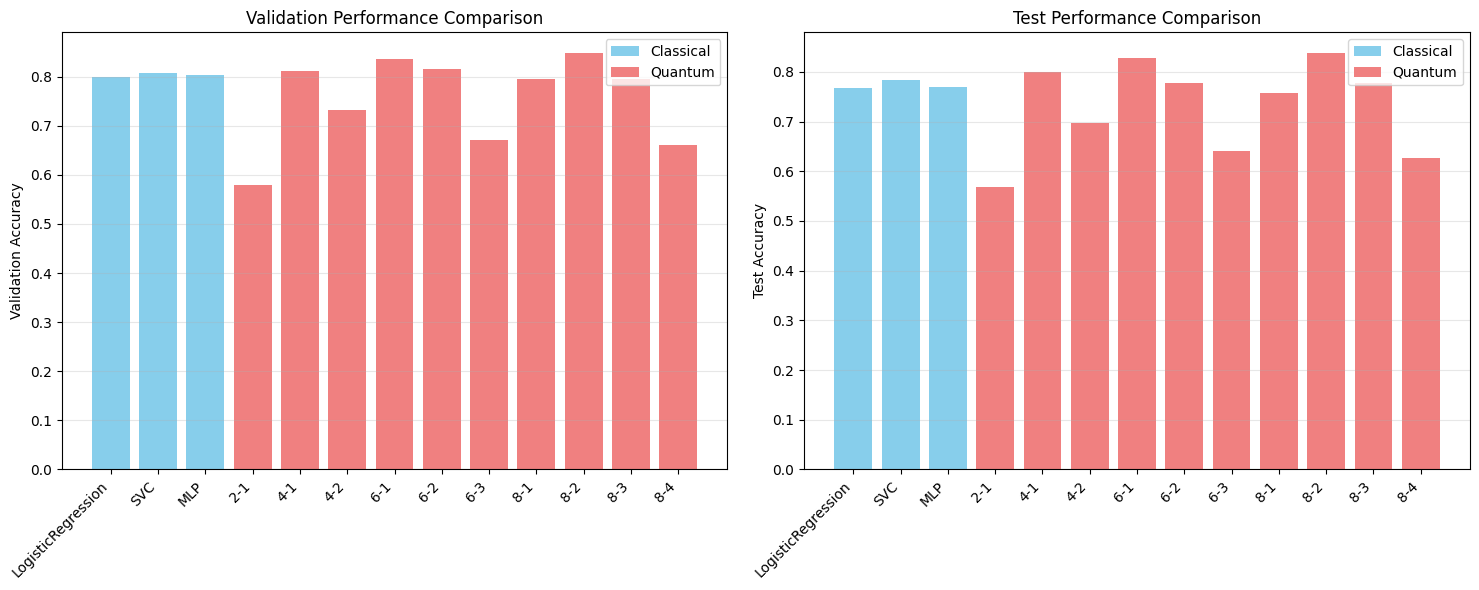


=== RESULTS SUMMARY ===

Classical Methods:
LogisticRegression   - Val: 0.8000, Test: 0.7669
SVC                  - Val: 0.8080, Test: 0.7846
MLP                  - Val: 0.8040, Test: 0.7701

Quantum Methods (best per mode count):
2 modes              - Val: 0.5800, Test: 0.5691
4 modes              - Val: 0.8120, Test: 0.7990
6 modes              - Val: 0.8360, Test: 0.8280
8 modes              - Val: 0.8480, Test: 0.8376


In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
# Extract results for visualization
classical_methods = ['LogisticRegression', 'SVC', 'MLP']
classical_val_accs = [results[method][0] for method in classical_methods]
classical_test_accs = [results[method][1] for method in classical_methods]

# Process quantum results
quantum_configs = list(results['Qlayer'].keys())
quantum_val_accs = [results['Qlayer'][config][0] for config in quantum_configs]
quantum_test_accs = [results['Qlayer'][config][1] for config in quantum_configs]

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Validation accuracies
x_classical = range(len(classical_methods))
x_quantum = range(len(classical_methods), len(classical_methods) + len(quantum_configs))
x_labels_quantum = [f"{c.split('-qlayer-')[0]}-{c.split('-qlayer-')[1]}" for c in quantum_configs]

ax1.bar(x_classical, classical_val_accs, color='skyblue', label='Classical')
ax1.bar(x_quantum, quantum_val_accs, color='lightcoral', label='Quantum')
ax1.set_xticks(list(x_classical) + list(x_quantum))
ax1.set_xticklabels(classical_methods + x_labels_quantum, rotation=45, ha='right')
ax1.set_ylabel('Validation Accuracy')
ax1.set_title('Validation Performance Comparison')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Test accuracies
ax2.bar(x_classical, classical_test_accs, color='skyblue', label='Classical')
ax2.bar(x_quantum, quantum_test_accs, color='lightcoral', label='Quantum')
ax2.set_xticks(list(x_classical) + list(x_quantum))
ax2.set_xticklabels(classical_methods + x_labels_quantum, rotation=45, ha='right')
ax2.set_ylabel('Test Accuracy')
ax2.set_title('Test Performance Comparison')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== RESULTS SUMMARY ===")
print("\nClassical Methods:")
for i, method in enumerate(classical_methods):
    print(f"{method:20s} - Val: {classical_val_accs[i]:.4f}, Test: {classical_test_accs[i]:.4f}")

print("\nQuantum Methods (best per mode count):")
modes_processed = set()
for config in quantum_configs:
    mode_count = config.split('-')[0]
    if mode_count not in modes_processed:
        # Find best accuracy for this mode count
        mode_configs = [c for c in quantum_configs if c.startswith(mode_count + '-')]
        best_val = max(results['Qlayer'][c][0] for c in mode_configs)
        best_test = max(results['Qlayer'][c][1] for c in mode_configs)
        print(f"{mode_count + ' modes':20s} - Val: {best_val:.4f}, Test: {best_test:.4f}")
        modes_processed.add(mode_count)


## 9. Results Summary and Visualization

Let's visualize and analyze the results from all classification heads.

In [41]:
save_experiment_results(results, "quantum_llm_finetuning_results.json")

print("\nExperiment completed successfully!")
print(f"Results saved to ./results/quantum_llm_finetuning_results.json")

Results saved. Total experiments: 2

Experiment completed successfully!
Results saved to ./results/quantum_llm_finetuning_results.json


## 10. Analysis and Conclusions

Based on the experimental results, we can draw several insights:

### Performance Comparison

1. **Classical Baselines**:
   - Logistic Regression provides a strong baseline despite its simplicity
   - SVM often performs competitively in few-shot scenarios
   - MLP can capture non-linear patterns but may overfit with limited data

2. **Quantum Classifiers**:
   - Performance varies with the number of modes and photons
   - Smaller quantum circuits (2-4 modes) often perform comparably to classical methods
   - Larger circuits may suffer from optimization challenges

### Key Observations

- **Few-shot learning**: With only 8 samples per class, simpler models often generalize better
- **Quantum advantage**: Quantum models show promise but require careful hyperparameter tuning
- **Computational trade-offs**: Quantum simulations are computationally intensive compared to classical methods

### Future Directions

1. **Scaling studies**: Test with more training samples to see if quantum models benefit from larger datasets
2. **Architecture exploration**: Try different quantum circuit designs and encoding strategies
3. **Hardware implementation**: Evaluate on real quantum photonic hardware when available
4. **Hybrid approaches**: Combine classical and quantum layers for potentially better performance

The results demonstrate that quantum photonic classifiers can achieve competitive performance in NLP tasks, opening new avenues for quantum-enhanced machine learning in language processing.